|Item|Description|
|:---|:---|
|Created |Jan 17, 2021|
|Author|BIMALKA PIYARUWAN|
|GitHub|https://github.com/bimalka98|

# Smoothed Sobel gradient and Laplacian for greater Sharpening

## The narrow dynamic range of the intensity levels and high noise content make this image difficult to enhance. The strategy we will follow is to utilize,

### 1. The Laplacian to highlight fine detail(Second Derivative for Image Sharpening)

Resultant image is sharpened but still noisy. To reduce the noise a median filter can be used. However, median filtering is a nonlinear process capable of removing image features. This is unacceptable in medical image processing. 

### 2. A smoothed version of the gradient image to mask the Laplacian image(Original + Laplacian).

The response of the gradient to noise and fine details is lower than the Laplacian’s and can be lowered further by smoothing the gradient with an averaging filter.

### 3. Increase the dynamic range of the intensity levels by using an intensity transformation.

Histogram equalization is not likely to work well on images that have dark intensity distributions like our images have here. Histogram specification could be a solution, but the dark characteristics of the images with which we are dealing lend themselves much better to a power-law transformation i.e Gamma Correction

[Original Image source](http://gamma.wustl.edu/bs044te241.html)

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

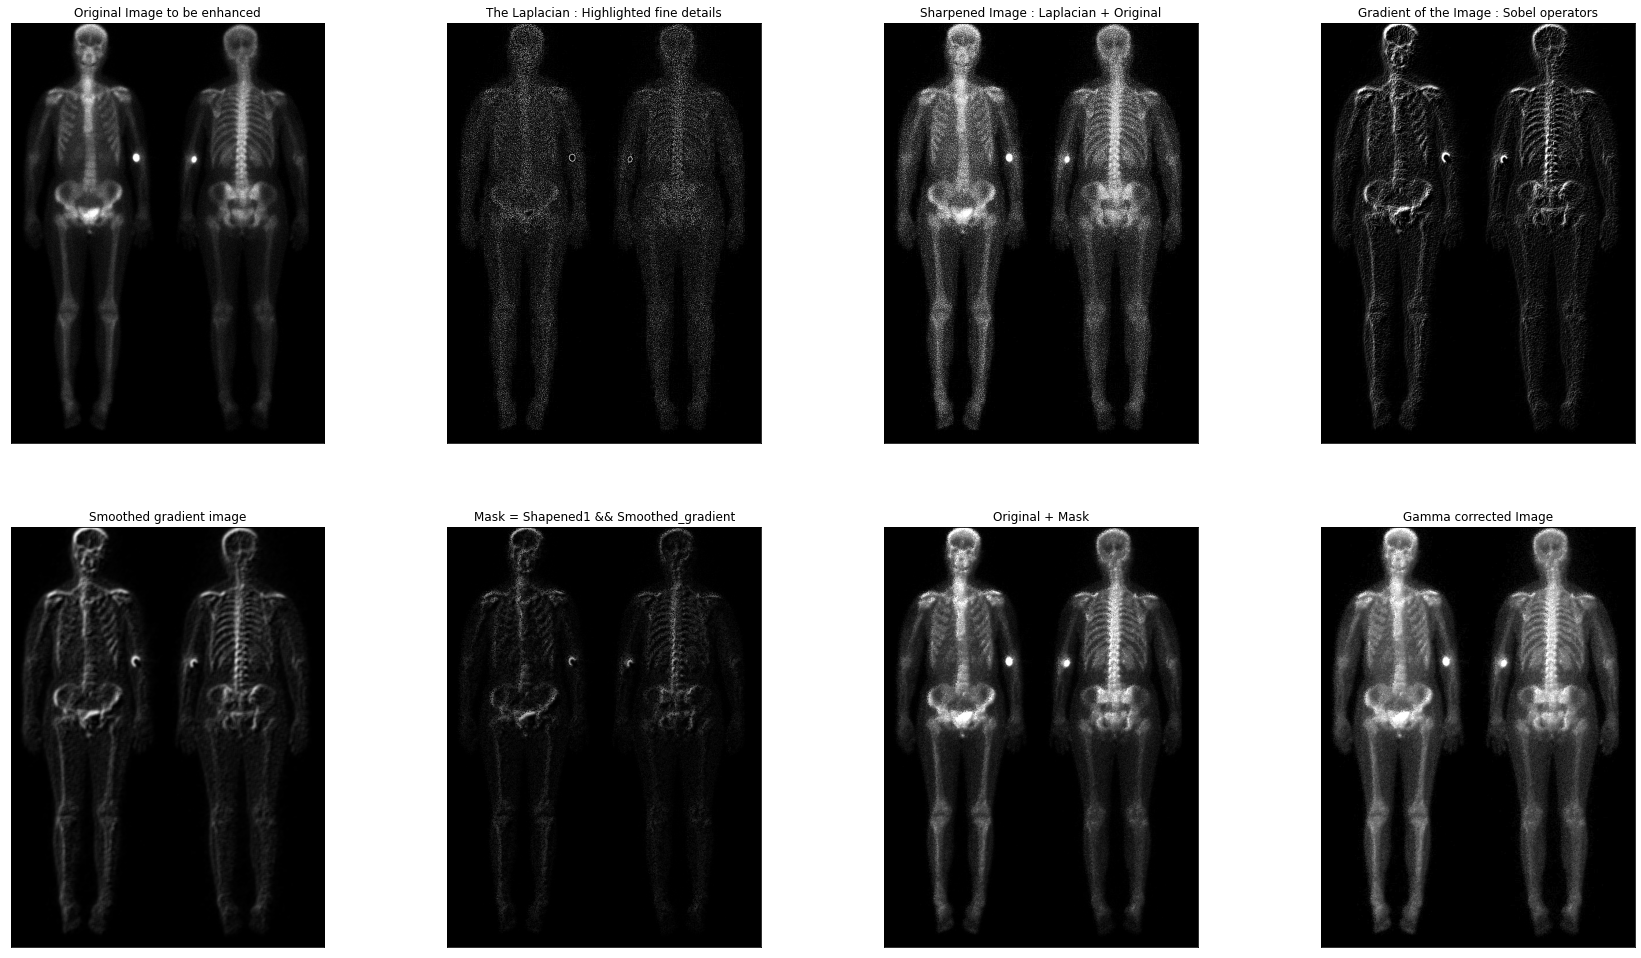

In [2]:
orgimg = cv.imread('Anterior and posterior whole body image.jpg', cv.IMREAD_GRAYSCALE)

# Using center positive laplacian kernel
kernel = np.array([(-1,-1,-1),(-1,8,-1),(-1,-1,-1)]) # Able to capture diagonal transitions too therfore-more filtering effect
transitions = cv.filter2D(orgimg, -1, kernel) # if center is positive in kernel transitions must be added
sharpened1 = cv.addWeighted( orgimg, 1.0, transitions, 1, 0) #Opencv addition is used because numpy addition saturates.

# Declaring sobel vertical and horizontal kernels
sobel_vertical_kernel = np.array([(-1, -2, -1), (0, 0, 0), (1, 2, 1)], dtype='float') #central differnce in vertical---> sobel vertical kernel
sobel_horizontal_kernel = np.array([(-1,0,1),(-2,0,2),(-1,0,1)], dtype='float') #central differnce in horizontal---> sobel horizontal kernel

# Calculating gradient of the original image using soble operators
img_hor_edges = cv.filter2D(orgimg,-1,sobel_vertical_kernel) # Horizontal edges are detcted by verical kernel--g_x
img_ver_edges = cv.filter2D(orgimg,-1,sobel_horizontal_kernel) # Vertical edges are detected by horizontal kernel--g_y
# -1 is the desired depth of the img

# |grad| = sqrt(g_x**2 + g_y**2) nearly equal to |g_x|+|g_y|
gradient_image = cv.addWeighted(img_hor_edges , 1.0,img_ver_edges , 1, 0) #Opencv addition is used because numpy addition saturates.

# Smooting through an averaging kernel
dimension = 5
kernel2 = np.ones((dimension,dimension),np.float32)/(dimension**2)# Averaging kernel sum = 1
smoothed_gradient_image = cv.filter2D(gradient_image, -1, kernel2)

#Mask image formed by the product of Sharpened1 and smoothed_gradient_image.

#mask = sharpened1.astype('float32')- smoothed_gradient_image.astype('float32')
#mask = np.multiply(sharpened1,smoothed_gradient_image)
mask = cv.bitwise_and(sharpened1,smoothed_gradient_image)
sharpened2 = cv.addWeighted( orgimg, 1.0, mask, 1, 0) #Opencv addition is used because numpy addition saturates.

# Gamma corection  
gamma = 1.35
LUT = np.array([(i/255.0)**(1.0/gamma)*255.0 for i in np.arange(0,256)]).astype('uint8')
img_gamma = cv.LUT(sharpened2, LUT)

'''***********************************************************************'''
# Plotting
img_dict = {'Original Image to be enhanced':orgimg, 'The Laplacian : Highlighted fine details': transitions, 
            'Sharpened Image : Laplacian + Original':sharpened1,'Gradient of the Image : Sobel operators':gradient_image,
            'Smoothed gradient image':smoothed_gradient_image,'Mask = Shapened1 && Smoothed_gradient':mask,
            'Original + Mask':sharpened2,'Gamma corrected Image':img_gamma }

fig, axes = plt.subplots(2,4, sharex='all', sharey='all', figsize=(30,17))
i =0
for key in img_dict.keys():
    plt.subplot(2,4,i+1),plt.imshow(img_dict[key], cmap='gray', vmin = 0, vmax = 255)
    plt.title(key),plt.xticks([]),plt.yticks([])
    i+=1
plt.show()